# Monoculture Logistic Growth Fit
This notebook performs a clean logistic growth fit on the two untreated monoculture datasets.

What you get:
- Data loading and preprocessing (day extraction and averaging)
- Logistic ODE fit with parameter bounds
- Sum of Squared Residuals (SSR) and Bayesian Information Criterion (BIC)
- Plot of data with fitted model curve and a concise parameter report

> Notes:
- Uses CSV, DataFrames, DifferentialEquations, Optimization, and BlackBoxOptim.
- If packages are missing, add them in your Julia REPL: Pkg.add("CSV"), etc.

In [ ]:
# 1) Packages
using Pkg
pkgs = [
    "CSV", "DataFrames", "Statistics",
    "DifferentialEquations", "DiffEqParamEstim",
    "Optimization", "OptimizationOptimJL",
    "BlackBoxOptim", "Plots", "Glob"
 ]
for p in pkgs
    try
        Base.eval(Main, :(import $(Symbol(p))))
    catch
        Pkg.add(p)
        Base.eval(Main, :(import $(Symbol(p))))
    end
end
println("✔ Packages ready: ", join(pkgs, ", "))

✔ Packages ready: CSV, DataFrames, Statistics, DifferentialEquations, DiffEqParamEstim, Optimization, OptimizationOptimJL, BlackBoxOptim, Plots


In [ ]:
# 2) Using imports
using CSV, DataFrames, Statistics
using DifferentialEquations
using DiffEqParamEstim
using Optimization, OptimizationOptimJL
using BlackBoxOptim
using Plots
using Printf
using Glob

In [13]:
# 3) Models
function logistic!(du, u, p, t)
    r, K = p
    du[1] = r * u[1] * (1 - u[1]/K)
end

logistic! (generic function with 1 method)

In [ ]:
# 4) Main functions (fast path; CSVs already contain day averages)
struct FitResult
    r::Float64
    K::Float64
    SSR::Float64
    BIC::Float64
end

# Helper: find a column by fuzzy name (case-insensitive substring match)
function _find_col(df::DataFrame; must_include::Vector{String}=[])
    for c in names(df)
        s = lowercase(String(c))
        ok = all(substr -> occursin(substr, s), must_include)
        ok && return Symbol(c)
    end
    return nothing
end

# Collapse duplicate x values by mean of y
function dedupe_xy(x::Vector{Float64}, y::Vector{Float64})
    df = DataFrame(day=x, value=y)
    g = combine(groupby(df, :day), :value => mean => :value)
    return Float64.(g.day), Float64.(g.value)
end

# Read pre-averaged data: look for a Day column and a mean/value column
function load_monoculture_csv(path::AbstractString; scale_if_area::Float64=1.0)
    df = CSV.read(path, DataFrame)
    # Try to detect the day column
    daycol = nothing
    if :day ∈ names(df)
        daycol = :day
    elseif :Day ∈ names(df)
        daycol = :Day
    else
        # any column whose name contains "day"
        daycol = _find_col(df; must_include=["day"])
    end
    daycol === nothing && error("Could not find a 'day' column in $(basename(path))")

    # Detect value column: prefer mean area if present; otherwise Average/Value/Cells
    valcol = _find_col(df; must_include=["mean","area"])  # e.g., "Mean Area µm^2" or similar
    if valcol === nothing
        for cand in (:Average, Symbol("Area µm^2"), :Value, :Cells)
            if cand ∈ names(df)
                valcol = cand
                break
            end
        end
    end
    valcol === nothing && error("No suitable value column found in $(basename(path)). Tried mean area / Average / Area µm^2 / Value / Cells")

    x = Float64.(df[!, daycol])
    y = Float64.(df[!, valcol])

    # Scale only if the value appears to be an area column (default no-op with scale_if_area=1.0)
    valname = lowercase(String(valcol))
    if occursin("area", valname)
        y ./= scale_if_area
    end

    # Sort and dedupe identical days by averaging y
    perm = sortperm(x)
    x = x[perm]; y = y[perm]
    return dedupe_xy(x, y)
end

# Fit logistic and compute SSR + BIC (adaptive bounds)
function fit_logistic(x::Vector{<:Real}, y::Vector{<:Real}; r_bounds::Tuple{Float64,Float64}=(0.0, 2.0), K_bounds::Union{Nothing,Tuple{Float64,Float64}}=nothing)
    x = collect(Float64.(x)); y = collect(Float64.(y))
    tspan = (x[1], x[end])
    u0 = [max(y[1], eps())]
    # Adaptive K upper bound near ~2-5x max observed
    ymax = maximum(y)
    k_hi = isnothing(K_bounds) ? max(100.0, 5*ymax) : K_bounds[2]
    k_lo = isnothing(K_bounds) ? max(ymax/10, 1.0) : K_bounds[1]
    bounds = [r_bounds, (k_lo, k_hi)]
    best_p, best_sol, best_loss = nothing, nothing, Inf
    solver = Rosenbrock23()
    for _ in 1:10
        p0 = [rand(Uniform(r_bounds...)), rand(Uniform(bounds[2]...))]
        prob = ODEProblem(logistic!, u0, tspan, p0)
        obj = build_loss_objective(prob, solver, L2Loss(x, y), Optimization.AutoForwardDiff())
        res = bboptimize(obj; SearchRange=bounds, MaxTime=20.0, TraceMode=:silent)
        p̂ = best_candidate(res)
        sol̂ = solve(remake(prob, p=p̂), solver; saveat=x, reltol=1e-9, abstol=1e-9)
        pred = getindex.(sol̂.u, 1)
        if length(pred) != length(y)
            # Safety: re-solve if mismatch
            sol̂ = solve(remake(prob, p=p̂), solver; saveat=x)
            pred = getindex.(sol̂.u, 1)
        end
        loss = sum(abs2.(y .- pred))
        if loss < best_loss
            best_p, best_sol, best_loss = p̂, sol̂, loss
        end
    end
    n = length(y); k = 2
    ssr = best_loss
    bic = n > k ? n*log(ssr/n) + k*log(n) : NaN
    return best_p, best_sol, FitResult(best_p[1], best_p[2], ssr, bic)
end

function plot_data_and_fit(x, y, sol; title_str="Logistic Fit")
    plt = scatter(x, y; label="Data", xlabel="Day", ylabel="Cells", title=title_str)
    plot!(plt, sol.t, getindex.(sol.u,1); label="Model", lw=2)
    display(plt)
end

plot_data_and_fit (generic function with 1 method)

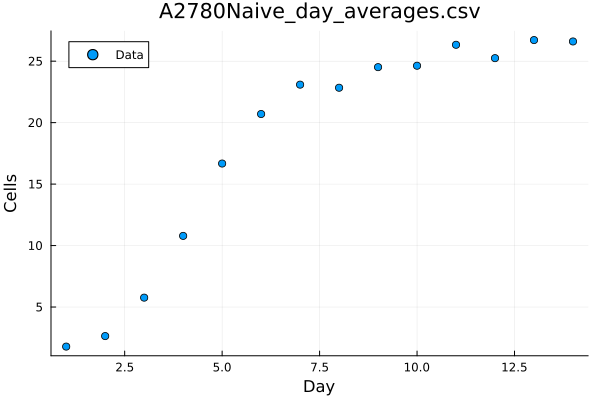

In [15]:
# 5) Data plot (single CSV quick check)
# Use processed day-average file provided
naive_csv = joinpath(pwd(), "Processed_Datasets", "Untreated MonoCulture", "20k", "Averages", "A2780Naive_day_averages.csv")
x_demo, y_demo = load_monoculture_csv(naive_csv; scale_if_area=157.7)
scatter(x_demo, y_demo; xlabel="Day", ylabel="Cells", title=basename(naive_csv), label="Data")

Demo Fit — r = 0.270477, K = 100.00
SSR = 1105.1191
BIC = 66.439


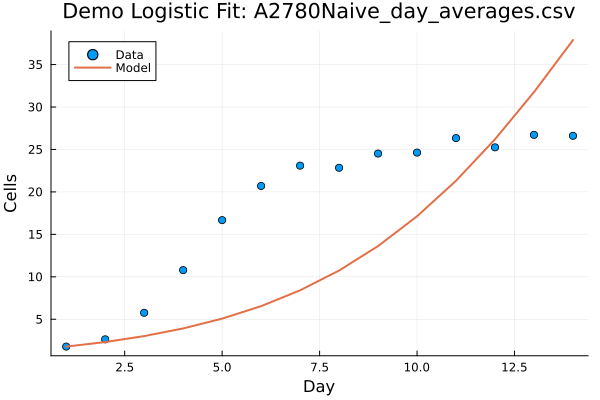

In [16]:
# 6) Main run cell (fit + plot for the demo CSV)
p̂_demo, sol_demo, fr_demo = fit_logistic(x_demo, y_demo)
@printf("Demo Fit — r = %.6f, K = %.2f\n", fr_demo.r, fr_demo.K)
@printf("SSR = %.4f\n", fr_demo.SSR)
@printf("BIC = %.3f\n", fr_demo.BIC)
plot_data_and_fit(x_demo, y_demo, sol_demo; title_str="Demo Logistic Fit: " * basename(naive_csv))

In [ ]:
# 7) Optional: Fit the other untreated monoculture CSV as well
resist_csv = joinpath(pwd(), "Processed_Datasets", "Untreated MonoCulture", "20k", "Averages", "A2780cis_sample_averages.csv")
x_r, y_r = load_monoculture_csv(resist_csv; scale_if_area=157.7)
p̂_r, sol_r, fr_r = fit_logistic(x_r, y_r)
@printf("Resistant Fit — r = %.6f, K = %.2f\n", fr_r.r, fr_r.K)
@printf("SSR = %.4f\n", fr_r.SSR)
@printf("BIC = %.3f\n", fr_r.BIC)
plot_data_and_fit(x_r, y_r, sol_r; title_str="Resistant Logistic Fit: " * basename(resist_csv))
println("\nSummary:")
@printf("Naive:  r=%.6f, K=%.2f, SSR=%.4f, BIC=%.3f\n", fr_demo.r, fr_demo.K, fr_demo.SSR, fr_demo.BIC)
@printf("Resist: r=%.6f, K=%.2f, SSR=%.4f, BIC=%.3f\n", fr_r.r, fr_r.K, fr_r.SSR, fr_r.BIC)

LoadError: DimensionMismatch: arrays could not be broadcast to a common size: a has axes Base.OneTo(48) and b has axes Base.OneTo(46)

In [ ]:
# 8) Batch run for all Averages CSVs in Untreated MonoCulture
using Glob
averages_dir = joinpath(pwd(), "Processed_Datasets", "Untreated MonoCulture")
patterns = [joinpath(averages_dir, "**", "Averages", "*.csv")]
files = String[]
for pat in patterns
    append!(files, glob(pat))
end
if isempty(files)
    @warn "No Averages CSVs found under $(averages_dir)"
else
    println("Found ", length(files), " files.")
end

results = DataFrame(File=String[], r=Float64[], K=Float64[], SSR=Float64[], BIC=Float64[])
for f in files
    try
        x, y = load_monoculture_csv(f; scale_if_area=157.7)
        _, sol, fr = fit_logistic(x, y)
        push!(results, (basename(f), fr.r, fr.K, fr.SSR, fr.BIC))
    catch e
        @warn "Failed on $(basename(f)): $e"
    end
end
println(results)